In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvelo as scv
import matplotlib.pyplot as plt
from spvelo import *

In [2]:
import scipy
def get_murk_genes(adata, cluster_edges, ct_key='cluster_annotations'):
    # initialize matrix for spliced (mat_s) and unspliced (unspliced) counts
    mat_s = pd.DataFrame(adata.layers['Ms'].copy())
    mat_u = pd.DataFrame(adata.layers['Mu'].copy())
    mat_s.index = adata.obs_names
    mat_s.columns = adata.var_names
    mat_u.index = adata.obs_names
    mat_u.columns = adata.var_names
    # initialize dataframes for slopes (df_sl) and slope error (df_ds)
    df_sl = pd.DataFrame(index = adata.var_names)
    df_ds = pd.DataFrame(index = adata.var_names)
    
    # compute slopes and errors
    population_names = list(set(adata.obs[ct_key]))
    for pop in population_names:
        vec = adata.obs[ct_key] == pop
        x = mat_s.loc[vec]
        y = mat_u.loc[vec]
        
        mx = np.mean(x)
        my = np.mean(y)
        x_mx = x - mx
        y_my = y - my
        xy = np.sum(x_mx * y_my, axis = 0)
        X2 = np.sum(x_mx**2,axis = 0)
        sl = xy / X2
        inter = my - sl * mx
        n = np.sum(vec)
                
        df_sl[pop] = pd.DataFrame(sl)     
    
        pred = sl * x + inter
        sse = (pred - y)**2
        SSE = np.sum(sse, axis = 0)
                
        ds = np.sqrt(SSE/(n-2)/X2)
        df_ds[pop] = pd.DataFrame(ds)
    # initialize dataframes for slopes (df_exp), expression error (df_de) and 95% quantile (df_quant)
    df_exp = pd.DataFrame(index = adata.var_names)
    df_de = pd.DataFrame(index = adata.var_names)
    df_quan = pd.DataFrame(index = adata.var_names)
    
    # compute average expression and its error
    for pop in population_names:
        vec = adata.obs[ct_key] == pop
        n = np.sum(vec)
        expr = np.mean(mat_s.loc[vec], axis = 0)
        dex = np.std(mat_s.loc[vec], axis = 0)/np.sqrt(n)
    
        df_exp[pop] = pd.DataFrame(expr)
        df_de[pop] = pd.DataFrame(dex)
        df_quan[pop] = scipy.stats.t.ppf(0.95, n - 1)
        
    # compute minimum and maximum estimates of the slopes
    df_conf = df_ds * df_quan
    df_min = df_sl - df_conf
    df_max = df_sl + df_conf
    
    vec_mean = (((df_exp['edge'] > df_exp['transitory'])
                &(df_exp['edge'] > df_exp['core']))
                &(df_exp['transitory'] > df_exp['core']))
    vec_sl = ((df_sl['edge'] > df_sl['transitory']) & (df_sl['edge'] > df_sl['core']))
    vec_pos =  df_sl['edge']>0
    vec_test = df_min['edge'] > df_max['transitory']
    vec_tot = ((np.array(vec_sl) & np.array(vec_mean) & np.array(vec_pos) & np.array(vec_test)))
    
    murk_genes = adata.var_names[vec_tot]
    return list(murk_genes)

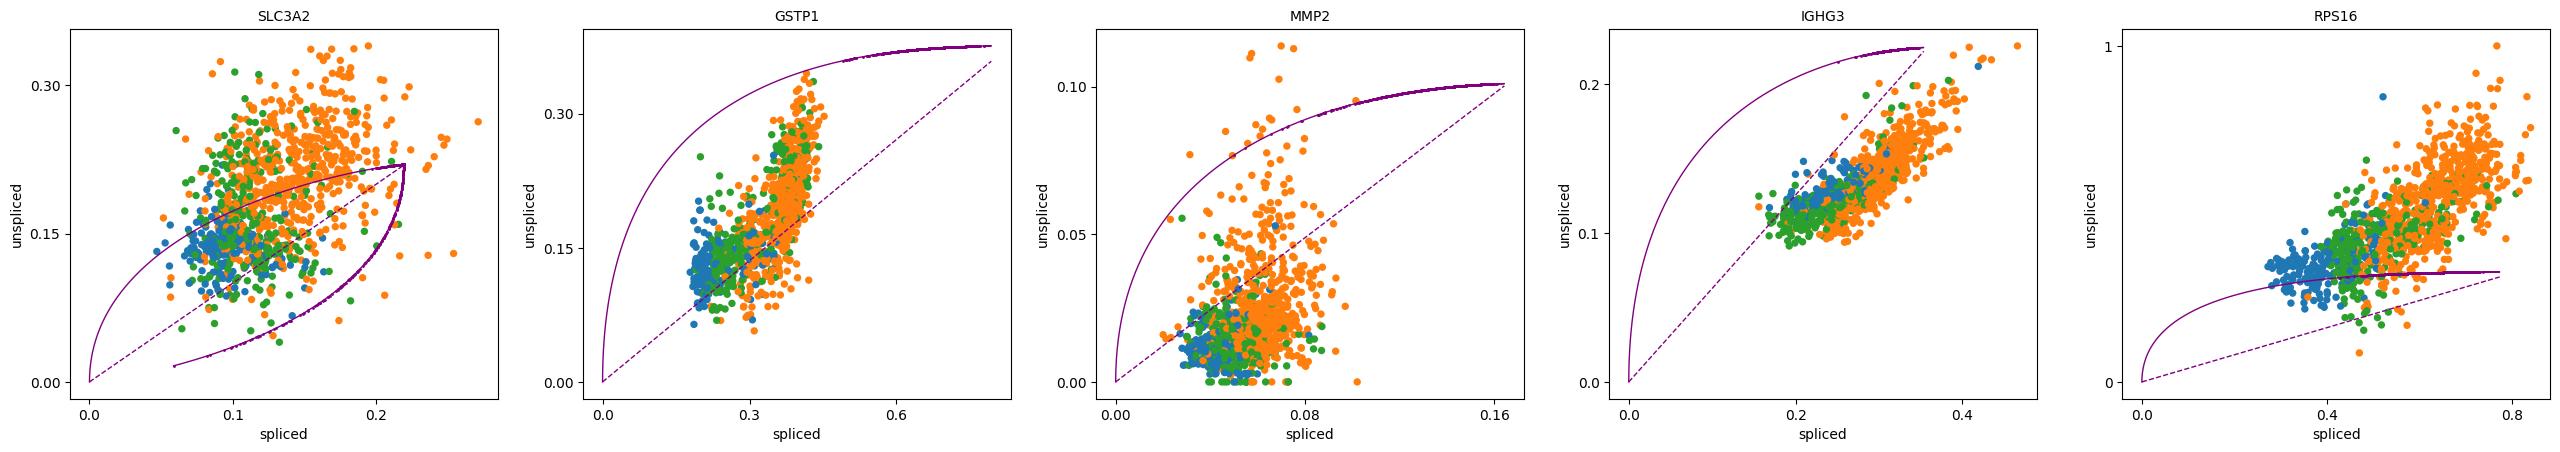

In [3]:
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_prefilter_mnn_mmd.h5ad')
bdata = adata[adata.obs.batch=='11'].copy()
murk_genes = ['SLC3A2', 'GSTP1', 'MMP2', 'IGHG3', 'RPS16']
scv.pl.scatter(bdata, murk_genes, color='cluster_annotations', ncols=5)

In [9]:
import gseapy
from collections import OrderedDict
from gseapy.stats import calc_pvalues, multiple_testing_correction
def parse_background(gmt):
    """
    set background genes
    """
    bg = set()
    for term, genes in gmt.items():
        bg = bg.union(set(genes))
    return bg
def get_gsea_scores(gene_list, gmt, pathway_list=None, cutoff=0.05):
    if pathway_list == None:
        pathway_list = list(gmt.keys())
    
    gmt = {k: gmt[k] for k in pathway_list}
    bg = parse_background(gmt)
    hgtest = list(calc_pvalues(query=gene_list, gene_sets=gmt, background=bg))
    if len(hgtest) > 0:
        terms, pvals, oddr, olsz, gsetsz, genes = hgtest
        fdrs, rej = multiple_testing_correction(
            ps=pvals, alpha=cutoff, method="benjamini-hochberg"
        )
        # save to a dataframe
        odict = OrderedDict()
        odict["Term"] = terms
        odict["Overlap"] = list(map(lambda h, g: "%s/%s" % (h, g), olsz, gsetsz))
        odict["P-value"] = pvals
        odict["Adjusted P-value"] = fdrs
        odict["Odds Ratio"] = oddr
        odict["Combined Score"] = -1 * np.log(pvals) * oddr
        # odict['Reject (FDR< %s)'%self.cutoff ] = rej
        odict["Genes"] = [";".join(map(str, g)) for g in genes]
        res = pd.DataFrame(odict)
    return res

In [10]:
markers = {}
merged_markers = {'core':[], 'transitory':[], 'edge':[]}
for sam in range(1,13):
    markers[sam] = {}
    bdata = adata[adata.obs.batch==str(sam)].copy()
    scv.tl.rank_velocity_genes(bdata, groupby='cluster_annotations')
    for ct in ['core', 'transitory', 'edge']:
        markers[sam][ct] = pd.DataFrame(bdata.uns['rank_velocity_genes']['names'])[:20][ct].tolist()
        merged_markers[ct].extend(pd.DataFrame(bdata.uns['rank_velocity_genes']['names'])[:20][ct].tolist())

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
ranking velocity genes
    finished (0:00:00) --> added 
   

In [11]:
from gseapy import Msigdb
import random
setup_seed(0)
msig = Msigdb()
gmt = msig.get_gmt(category='c6.all', dbver="2023.2.Hs")
genes = list(set(merged_markers['transitory']+merged_markers['edge']))
original_adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/concat_pp_wonc.h5ad')
random_genes = random.sample([gene for gene in original_adata.var_names if gene not in genes], len(genes))
df_pos = get_gsea_scores(genes, gmt)
df_neg = get_gsea_scores(random_genes, gmt)
df_pos['gene_set'] = "transitory+edge"
df_neg['gene_set'] = "random"
df = pd.concat([df_pos, df_neg])
df

[rank: 0] Global seed set to 0


,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,gene_set
0,AKT_UP.V1_UP,3/169,0.116430,0.373737,3.016164,6.486161,FABP5;METRNL;MPZL2,transitory+edge
1,AKT_UP_MTOR_DN.V1_UP,3/178,0.130380,0.373737,2.859080,5.824813,METRNL;MPZL2;S100A8,transitory+edge
2,ALK_DN.V1_DN,2/139,0.256435,0.535053,2.581216,3.512723,IFI27;IGFBP6,transitory+edge
3,ALK_DN.V1_UP,1/141,0.633264,0.758583,1.495429,0.683213,CSTA,transitory+edge
4,ATF2_S_UP.V1_DN,3/187,0.144893,0.373737,2.717321,5.249210,NEAT1;CSTA;A2M,transitory+edge
...,...,...,...,...,...,...,...,...
72,VEGF_A_UP.V1_UP,1/195,0.635958,0.674800,1.484402,0.671874,OPTN,random
73,WNT_UP.V1_DN,1/172,0.589487,0.674800,1.687101,0.891638,IRF7,random
74,WNT_UP.V1_UP,2/176,0.227682,0.674800,2.813412,4.163308,MAZ;CD74,random
75,YAP1_DN,1/47,0.214858,0.674800,6.294972,9.680275,MYO1B,random


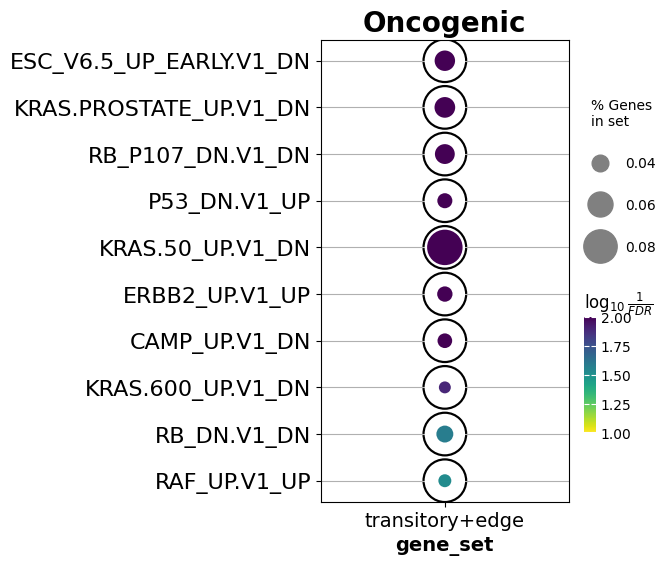

In [12]:
ax = gseapy.dotplot(df,
                x='gene_set',
                x_order = ["transitory+edge", "random"],
                title="Oncogenic", column='Adjusted P-value', 
                size=50, marker='o',
                show_ring=True)
plt.show()